In [1]:
#!pip install --upgrade ~/Development/repos/tradeframework
#!pip install --upgrade ~/Development/repos/tradeframework-insights
#!pip install --upgrade ~/Development/repos/quantutils
#!pip install --upgrade ~/Development/repos/marketinsights-price-aggregator

# Pkg imports
# TODO - dynamic import of SandboxEnv
from tradeframework.environments import SandboxEnvironment  
from marketinsights.api.aggregator import MarketDataAggregator
from marketinsights.remote.ml import MIAssembly
from marketinsights.remote.models import MIModelServer
import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils
import tradeframework.operations.plot as plotter
import tradeframework.operations.utils as utils
from tradeframework.api.insights import InsightManager

# Dev imports
import pandas as pd
import numpy as np

#import matplotlib
#%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

import warnings
warnings.filterwarnings(action='ignore')


2023-04-14 14:53:39.153887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 14:53:39.290776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-14 14:53:39.290798: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-14 14:53:40.398015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
#modelsvr = MIModelServer(secret="marketinsights-k8s-cred")
#assembly = MIAssembly(modelsvr, secret="marketinsights-k8s-cred")

In [2]:
data_config = [
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "location": "http://pricestore.192.168.1.203.nip.io"
        },
        "timezone": "UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID": "WallSt-hourly",
                        "sample_unit": "H"
                    },
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            },
            {
                "ID": "SPY",
                "sources": [
                    {
                        "ID":"SP500-hourly",
                        "sample_unit":"H"
                    },
                    {
                        "ID":"SANDP-500",
                        "sample_unit":"5min"
                    }
                ]
            }
        ]
    }
]


## Get Market Data
aggregator = MarketDataAggregator(data_config)
   
#start = "2013-01-01" # Train period
#end = "2018-08-01"

#start="2018-08-02" # Test period
#end="2018-12-31"

start="2018-08-02" # Test period
end="2025-12-31"

marketData = aggregator.getData(mkts=["DOW"], sample_unit="D", start=start, end=end, aggregate=True, debug=False)
print("Data Loaded")
#marketData = marketData.xs("mID")
#marketData = marketData.tz_convert("US/Eastern", level="Date_Time")
#marketData = marketData.unstack(level=0).dropna(axis=1).stack() # Remove rows that don't have values from all markets
#tickers = marketData.index.get_level_values("mID").unique().values


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

Data Loaded


In [3]:
env = SandboxEnvironment("TradeFair", "US/Eastern")
env.createAssets(marketData)

p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer"))
env.setPortfolio(p)

# Create baseline as an unweighted asset
baseline = env.createDerivative("Baseline Signal", weightGenerator=env.createModel("BuyAndHold", opts={"barOnly": True}))
baseline.addStoredAsset(["DOW"])
p.addAsset(baseline, weighted=False)

# Create baseline as an unweighted asset
baseline2 = env.createDerivative("MaxReturn", weightGenerator=env.createModel("MaxReturn", opts={"start":"19:00", "end":"20:00", "barOnly": True}))
baseline2.addStoredAsset(["DOW"])
#p.addAsset(baseline2, weighted=False)

# Create baseline as an unweighted asset
baseline3 = env.createDerivative("MinReturn", weightGenerator=env.createModel("MinReturn", opts={"start":"19:00", "end":"20:00", "barOnly": True}))
baseline3.addStoredAsset(["DOW"])
#p.addAsset(baseline3, weighted=False)

# BuyAndHold
p.addAsset(
    env.createDerivative(
        "BuyAndHold", 
        weightGenerator=env.createModel(
            "BuyAndHold", 
            #opts={"start":"19:00", "end":"20:00", "barOnly": True}
            opts={"barOnly": True}
        )).addStoredAsset(["DOW"]))

# ARIMA
""" p.addAsset(
    env.createDerivative(
        "ARIMA", 
        weightGenerator=env.createModel(
            "ARIMA", 
            modelModule="tradeframework.models.remote",
            opts={"AR":4, "I":1, "MA":2, "window":5*4*3, "fit":"inSample", "barOnly": True}
        )).addStoredAsset(["DOW"]))
 """
# ML Model
#p.addAsset(
#    env.createDerivative(
#        "mlmodel", 
#        weightGenerator=env.createModel(
#            "MIBasicModel", 
#            modelModule="tradeframework.models.remote",
#            opts={"window": 2, "modelSvr": modelsvr, "secret":"marketinsights-k8s-cred", "trainingRunId":"mlmodel", "threshold":0.8, "barOnly": True}
#        )).addStoredAsset(["DOW"]))

# Feed data into the portfolio
env.refresh()


AttributeError: 'tuple' object has no attribute 'spines'

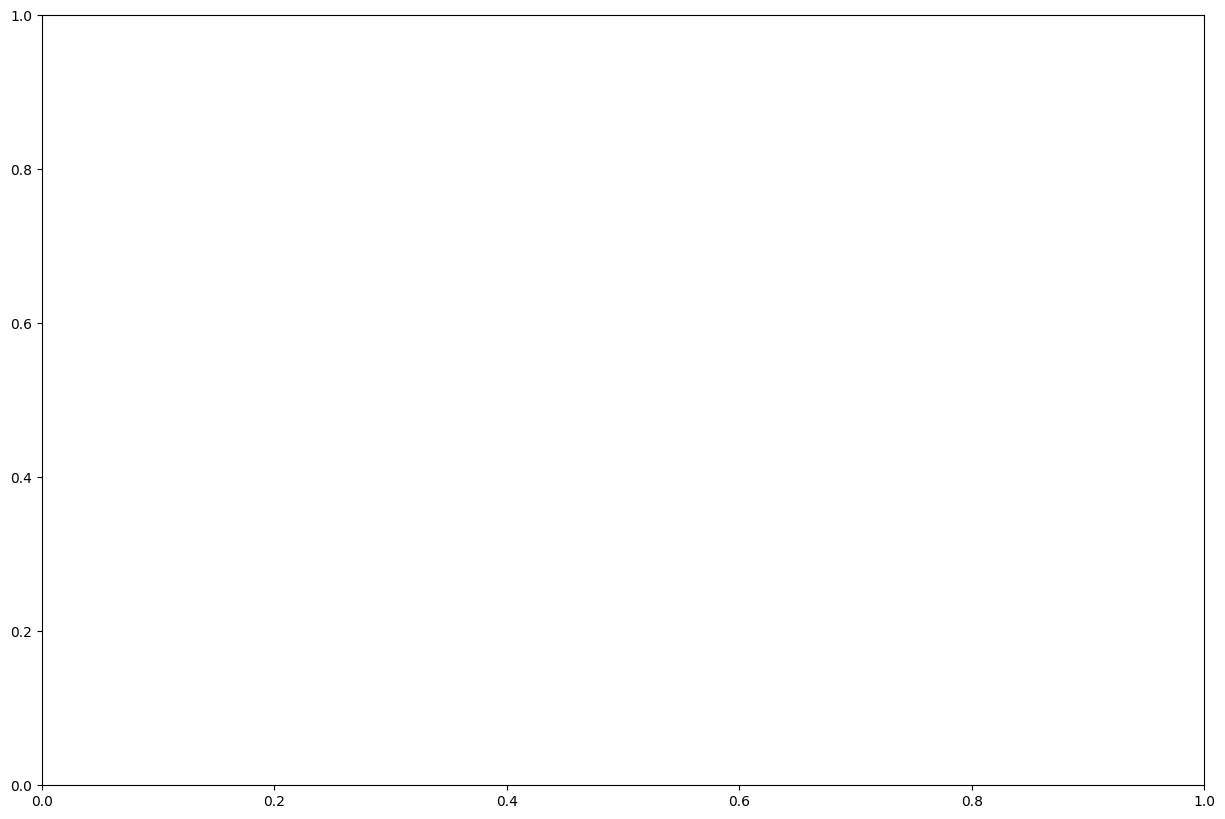

In [4]:
im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("TimeSeriesPlot"))
im.addInsightGenerator(im.createInsightGenerator("CorrelationMap", opts={"baseline":p.assets[0]}))

results = im.generateInsights()

In [14]:
result["ARIMAFit"].params

const     3.772265e-04
ar.L1    -6.597353e-07
ar.L2    -3.107909e-07
ar.L3    -2.865522e-08
ma.L1    -6.600097e-07
ma.L2    -3.110635e-07
sigma2    4.693408e-05
dtype: float64

In [11]:
result["ARIMAFit"].bse

const     1.804252e-04
ar.L1     7.356942e-03
ar.L2     7.427184e-03
ar.L3     1.451847e-02
ma.L1     7.356940e-03
ma.L2     7.427183e-03
sigma2    8.861496e-07
dtype: float64

In [6]:
import quantutils.core.statistics as stats
stats.mean_sign_accuracy([1,2,-3], [3,4,5])

0.6666666666666666

ARIMA:3,1,2, AIC:16981.847261606035, MFE:27.511620705254387, MAE:271.332973922613
Model Parameters



ar.L1         -1.621396
ar.L2         -0.708468
ar.L3          0.067544
ma.L1          1.557231
ma.L2          0.683152
sigma2    126307.320671
dtype: float64

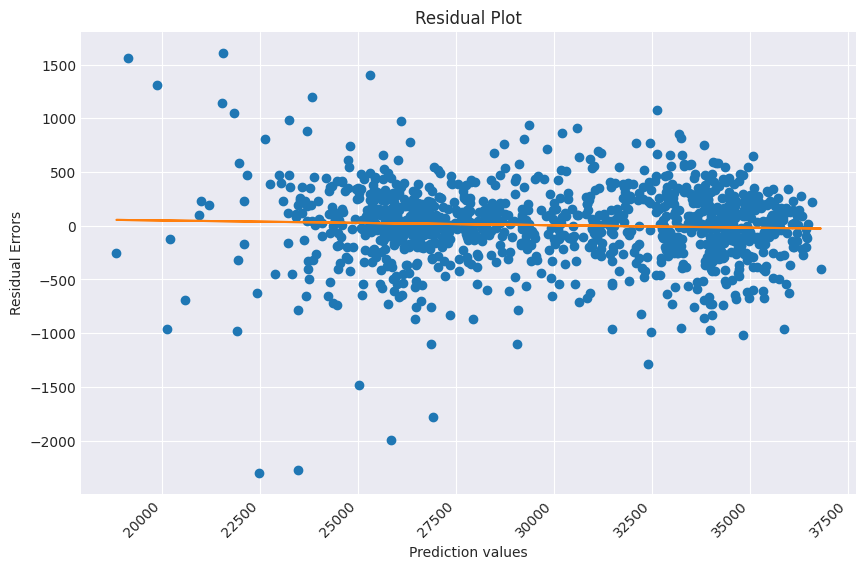


Prediction Metrics

Mean Forecast Error (MFE): 5.740779450486766
Mean Absolute Error (MAE): 249.77178129485947
Max. Error: 2299.4801595343197
Residual Standard Error (RSE): 356.63348320804556
Mean Absolute Percentage Error (MAPE): 0.008681925008306024
Mean Absolute Standard Error (MASE): 0.9996955792553386

R-Squared: 0.9918752485061046
Mean Directional Accuracy (MDA): 0.540447504302926%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1163.0
Lost : 0.0
Total : 1163.0
Diff : 1163.0
Edge : 100.0%
IR : 34.102787
Accuracy: 100.00%



In [13]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

y = p.findAsset("DOW").values["Close"]

im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y, "order":(3,1,2)})).generateInsights()
yhat = result["ARIMAFit"].predict()

im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"lags":30}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": y_trans}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat[1:], "y_series": y[1:] - yhat[1:], "title": "Residual Plot", "y_label":"Residual Errors"}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y[1:], "predictions": yhat[1:]}))

#im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": y_trans[1:] - yhat_trans, "title": "Residual Plot", "y_label":"Residual Errors"}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": resid, "title": "Residual Plot", "y_label":"Residual Errors"}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y_trans[1:], "predictions": yhat_trans}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y_trans, "predictions": yhat_trans, "ddof": 7}))
#im.addInsightGenerator(im.createInsightGenerator("BasicPlot", opts={"log":False}))
#im.addInsightGenerator(im.createInsightGenerator("PerfSummary", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
#im.addInsightGenerator(im.createInsightGenerator("StatisticalTests", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
    
results = im.generateInsights()

ARIMA:3,1,2, AIC:-12350.46726109814, MFE:0.005841208421495376, MAE:0.009943854191773054
Model Parameters



ar.L1    -6.005327e-07
ar.L2    -2.370916e-07
ar.L3     5.702973e-08
ma.L1    -6.008223e-07
ma.L2    -2.373790e-07
sigma2    4.708505e-05
dtype: float64

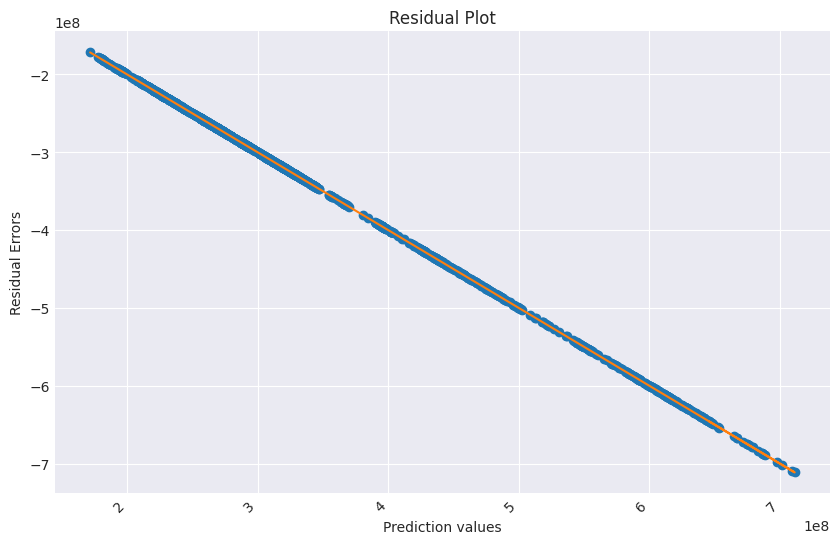


Prediction Metrics

Mean Forecast Error (MFE): -348319222.65739286
Mean Absolute Error (MAE): 348319222.65739286
Max. Error: 711422433.7329915
Residual Standard Error (RSE): 370242871.0220202
Mean Absolute Percentage Error (MAPE): 18386.692840406726
Mean Absolute Standard Error (MASE): 4206119.41548321

R-Squared: -13687846609.911566
Mean Directional Accuracy (MDA): 0.4786620530565167%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1735.0
Lost : 0.0
Total : 1735.0
Diff : 1735.0
Edge : 100.0%
IR : 41.65333
Accuracy: 100.00%



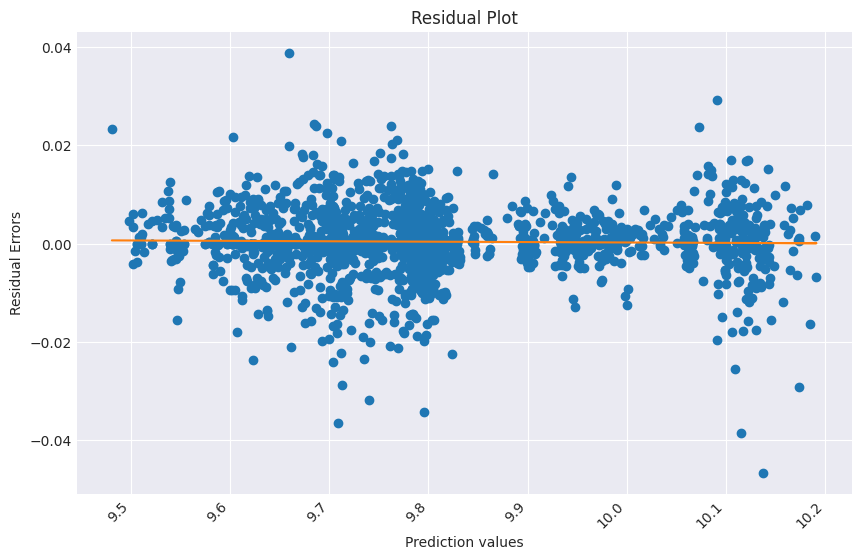


Prediction Metrics

Mean Forecast Error (MFE): 0.0003802042247374688
Mean Absolute Error (MAE): 0.00448521463234672
Max. Error: 0.0465953814321054
Residual Standard Error (RSE): 0.006863009425033743
Mean Absolute Percentage Error (MAPE): 0.0004573183028381019
Mean Absolute Standard Error (MASE): 1.002420294614261

R-Squared: 0.9982409837917889
Mean Directional Accuracy (MDA): 0.4331026528258362%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1735.0
Lost : 0.0
Total : 1735.0
Diff : 1735.0
Edge : 100.0%
IR : 41.65333
Accuracy: 100.00%



In [10]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

def inv_trans(y, yhat):
    return np.exp(np.log(y).shift() + yhat)[1:]

def trans(y):
    return np.log(y)

y = p.findAsset("DOW").values["Close"]
y_trans = trans(y)

im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y_trans, "order":(3,1,2)})).generateInsights()
yhat_trans = result["ARIMAFit"].predict()[1:]
yhat = inv_trans(y, yhat_trans)


im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"lags":30}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": y_trans}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat, "y_series": y[1:] - yhat, "title": "Residual Plot", "y_label":"Residual Errors"}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y[1:], "predictions": yhat}))

im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": y_trans[1:] - yhat_trans, "title": "Residual Plot", "y_label":"Residual Errors"}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": resid, "title": "Residual Plot", "y_label":"Residual Errors"}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y_trans[1:], "predictions": yhat_trans}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y_trans, "predictions": yhat_trans, "ddof": 7}))
#im.addInsightGenerator(im.createInsightGenerator("BasicPlot", opts={"log":False}))
#im.addInsightGenerator(im.createInsightGenerator("PerfSummary", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
#im.addInsightGenerator(im.createInsightGenerator("StatisticalTests", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
    
results = im.generateInsights()

ARIMA:3,0,2, AIC:-6753.885295079853, MFE:7.508763266641597e-05, MAE:0.008683663572744289
Model Parameters


const     0.000120
ar.L1    -1.359069
ar.L2    -0.396997
ar.L3     0.144992
ma.L1     1.269573
ma.L2     0.422298
sigma2    0.000173
dtype: float64

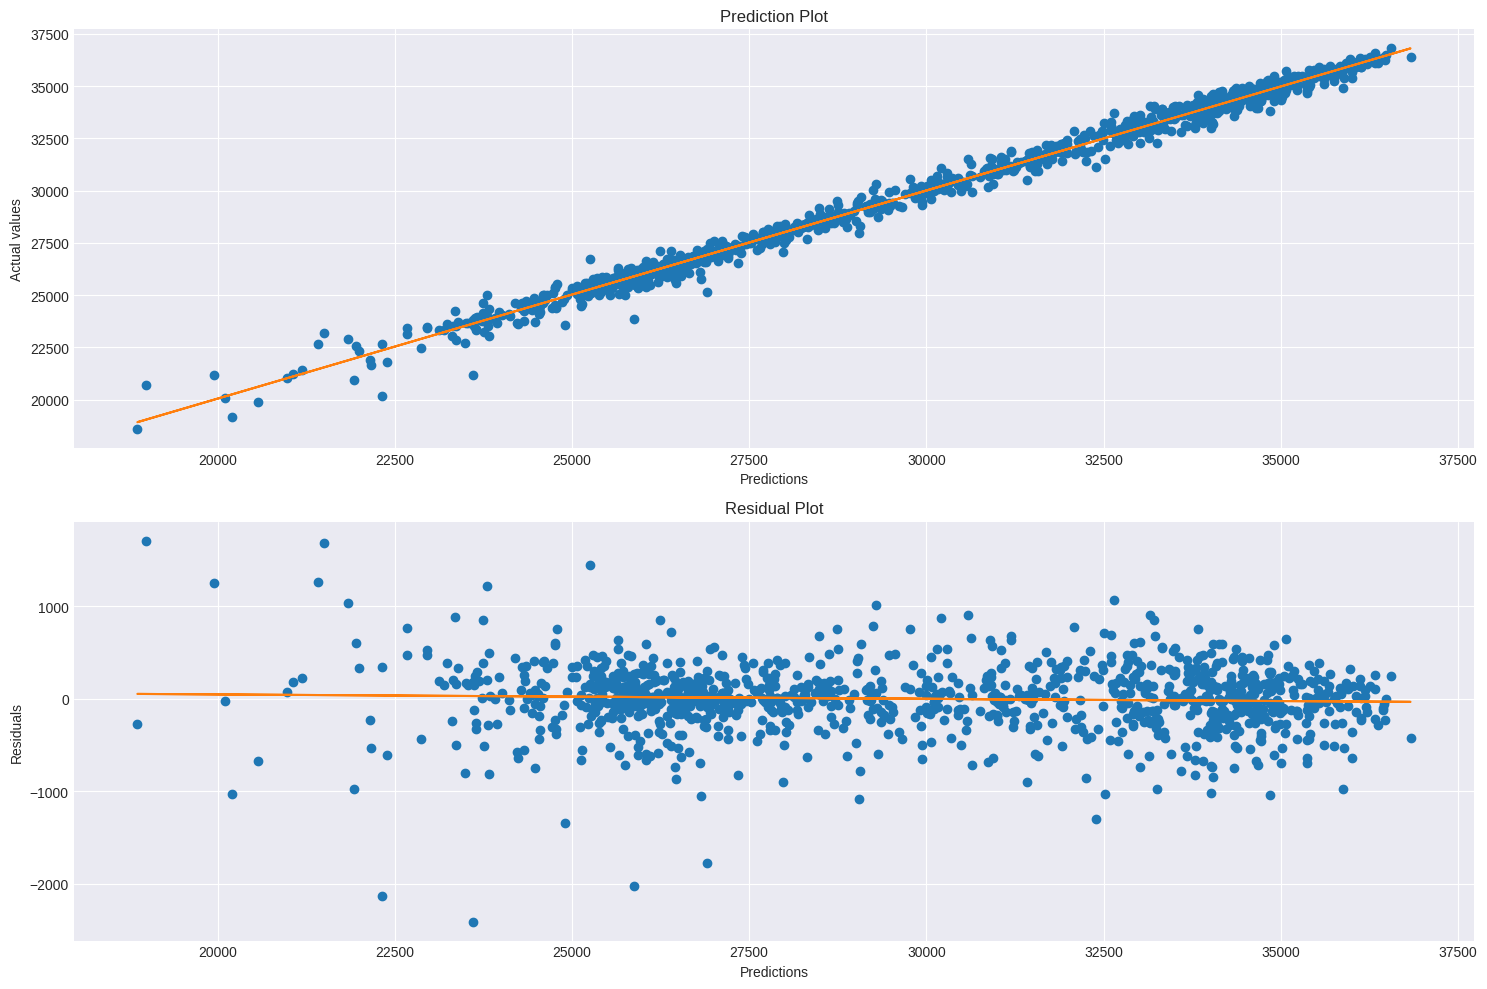

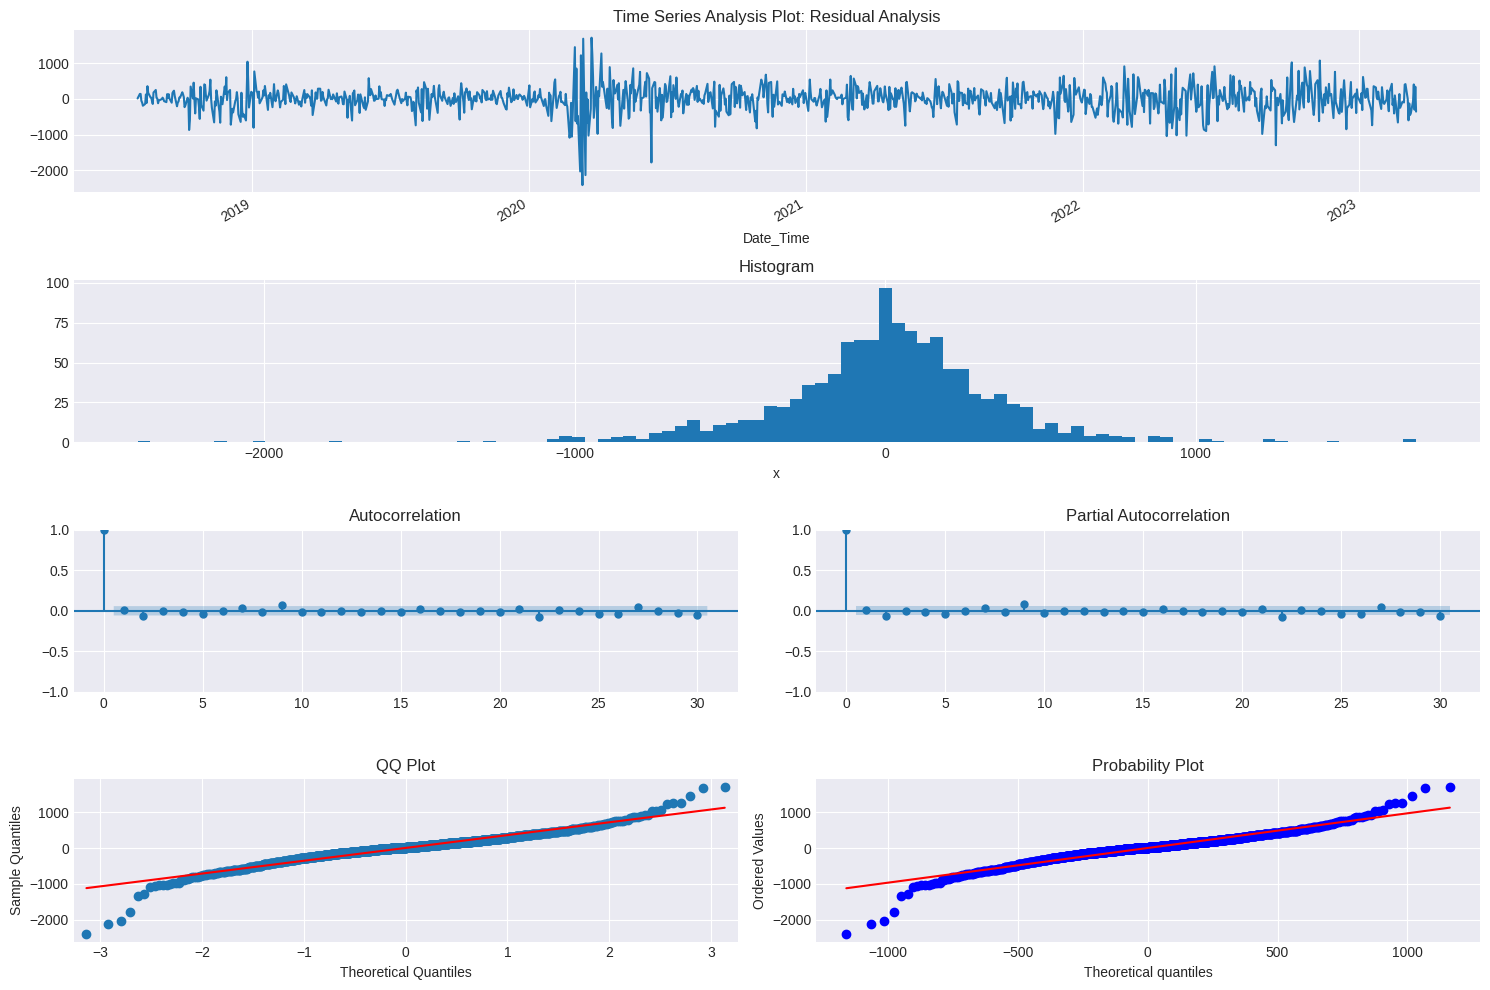


Prediction Metrics

Mean Forecast Error (MFE): 1.9375997913645318
Mean Absolute Error (MAE): 250.42838041510652
Max. Error: 2408.423378249343
Residual Standard Error (RSE): 358.08091854250046
Mean Absolute Percentage Error (MAPE): 0.008694106162251213
Mean Absolute Standard Error (MASE): 1.0023235752381154

R-Squared: 0.9918091643178875
Mean Directional Accuracy (MDA): 0.5292598967297762%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1163.0
Lost : 0.0
Total : 1163.0
Diff : 1163.0
Edge : 100.0%
IR : 34.102787
Accuracy: 100.00%



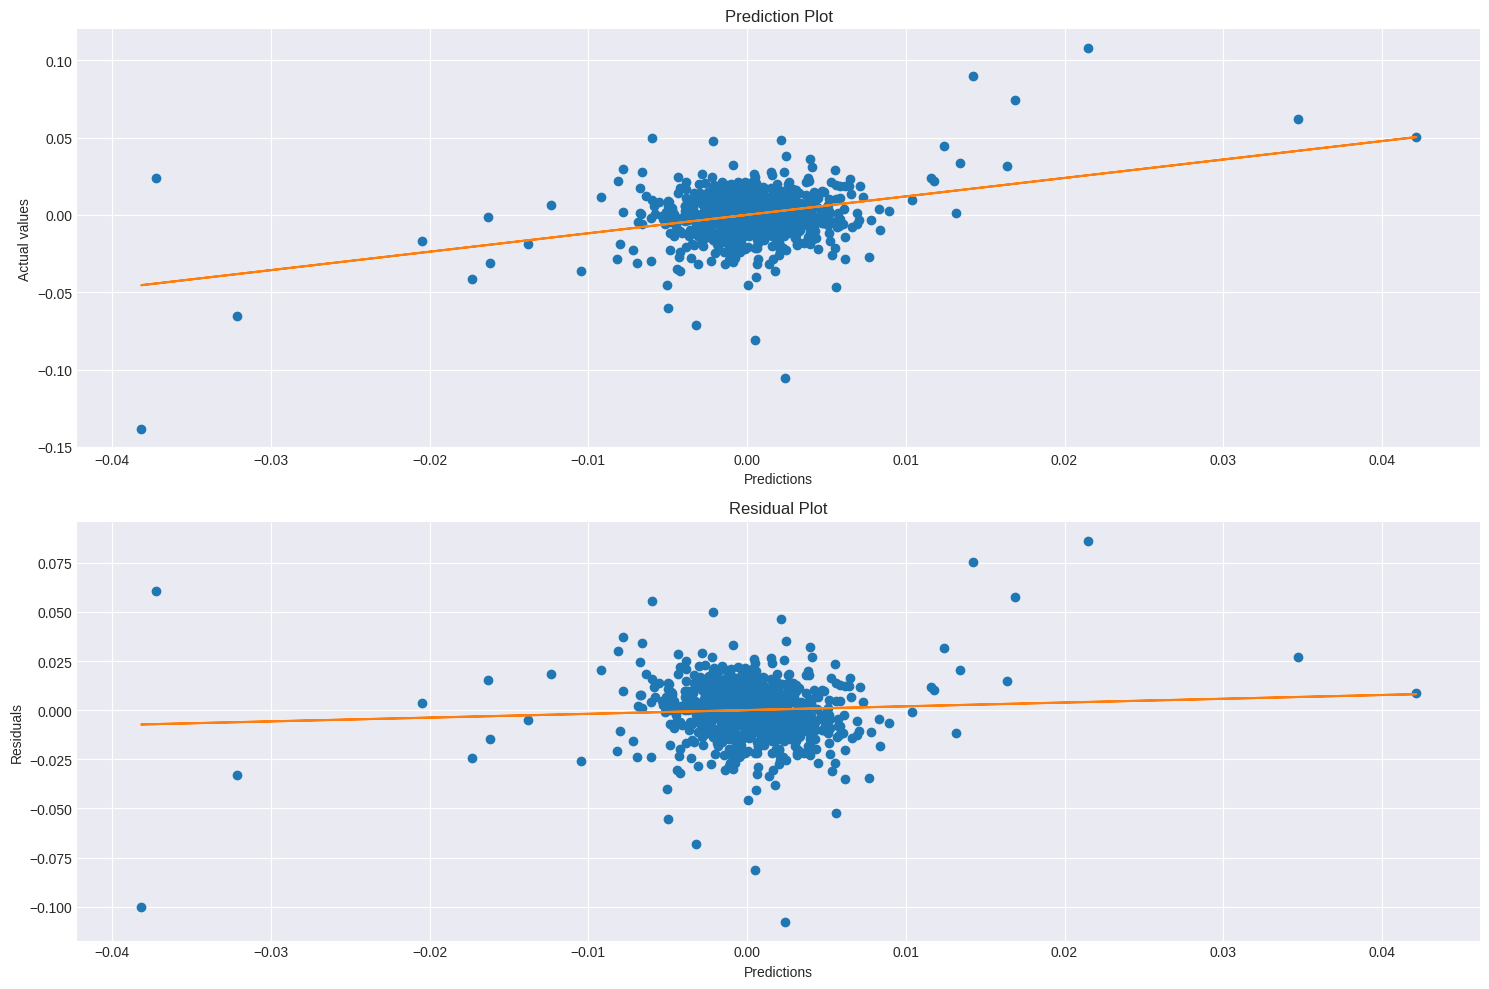

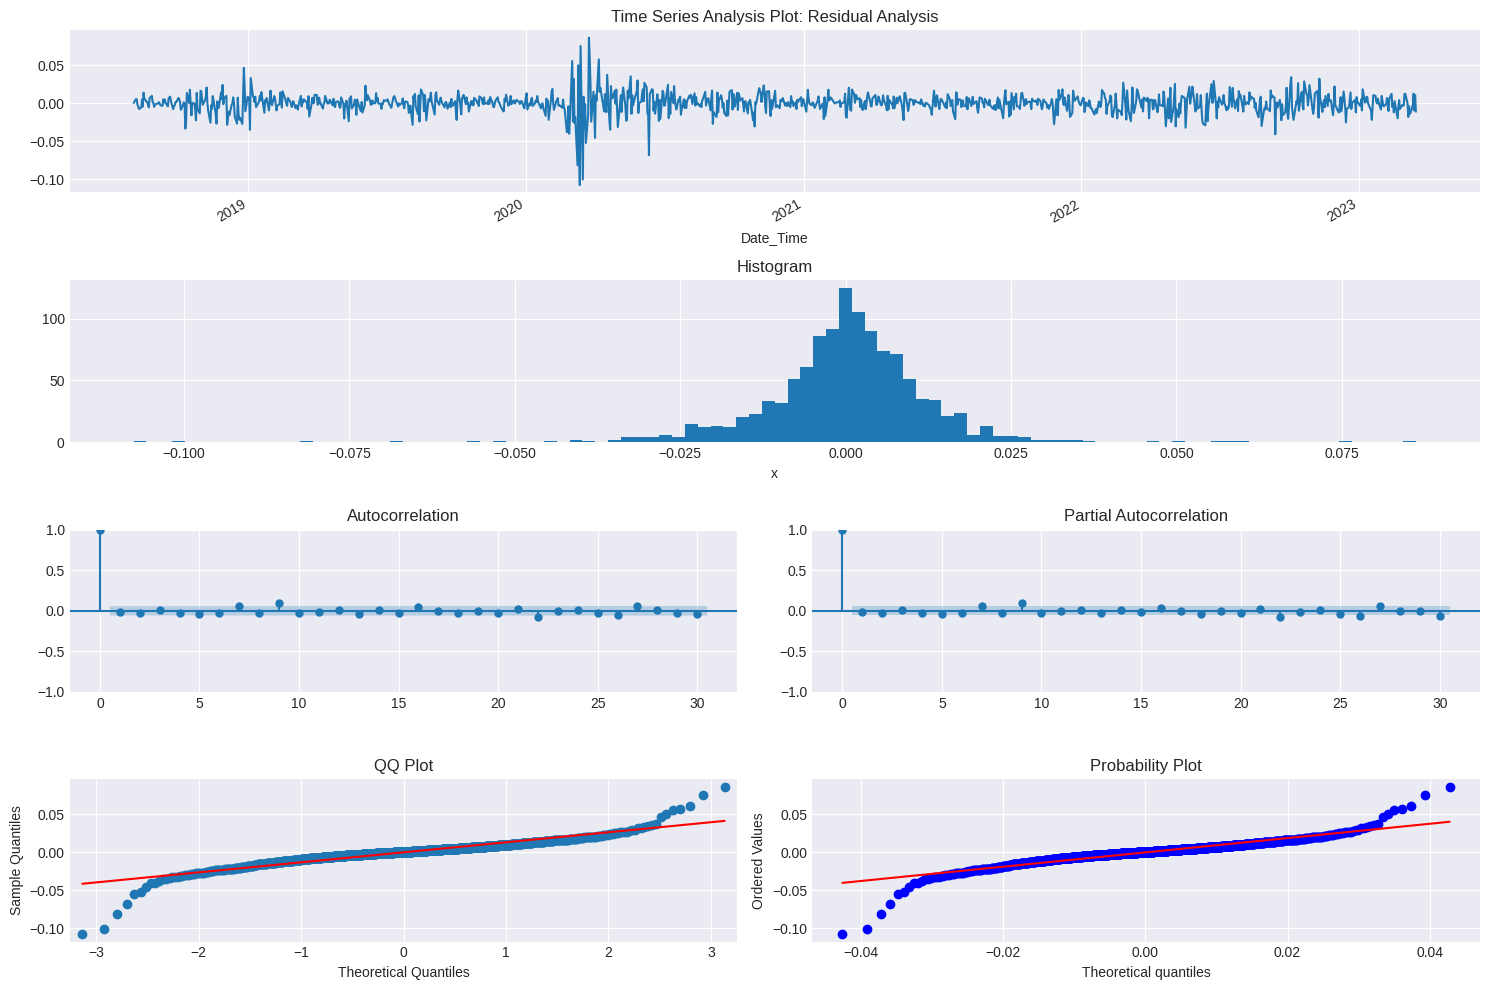


Prediction Metrics

Mean Forecast Error (MFE): 0.00007472919496812854
Mean Absolute Error (MAE): 0.008690713548075327
Max. Error: 0.10759596174187731
Residual Standard Error (RSE): 0.013190116730028357
Mean Absolute Percentage Error (MAPE): 3955049246.1248074
Mean Absolute Standard Error (MASE): 0.6720575870529135

R-Squared: 0.10859403532073009
Mean Directional Accuracy (MDA): 0.7493540051679587%
Mean Sign Accuracy (MSA): 0.5292598967297762%

Directional Metrics

Won : 615.0
Lost : 547.0
Total : 1162.0
Diff : 68.0
Edge : 5.851979345955249%
IR : 1.9948297
Accuracy: 52.93%



In [6]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

def inv_trans(y, yhat):
    return np.exp(np.log(y).shift() + yhat)[1:]

def trans(y):
    return np.log(y).diff()[1:]

y = p.findAsset("DOW").values["Close"]
y_trans = trans(y)

im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y_trans, "order":(3,0,2)})).generateInsights()
yhat_trans = result["ARIMAFit"].predict()
yhat = inv_trans(y, yhat_trans)


im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"lags":30}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": y_trans}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat, "actuals": y[1:]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y[1:], "predictions": yhat}))

im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat_trans, "actuals": y_trans}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": resid, "title": "Residual Plot", "y_label":"Residual Errors"}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y_trans[1:], "predictions": yhat_trans[1:]}))
#im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y_trans, "predictions": yhat_trans, "ddof": 7}))
#im.addInsightGenerator(im.createInsightGenerator("BasicPlot", opts={"log":False}))
#im.addInsightGenerator(im.createInsightGenerator("PerfSummary", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
#im.addInsightGenerator(im.createInsightGenerator("StatisticalTests", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
    
results = im.generateInsights()


ARIMA:3,0,2, AIC:-6764.116825131872, MFE:-2.901702059095676e-05, MAE:0.00872033467886619
Model Parameters



const     0.000228
ar.L1    -1.389310
ar.L2    -0.393259
ar.L3     0.190572
ma.L1     1.344334
ma.L2     0.493910
sigma2    0.000173
dtype: float64

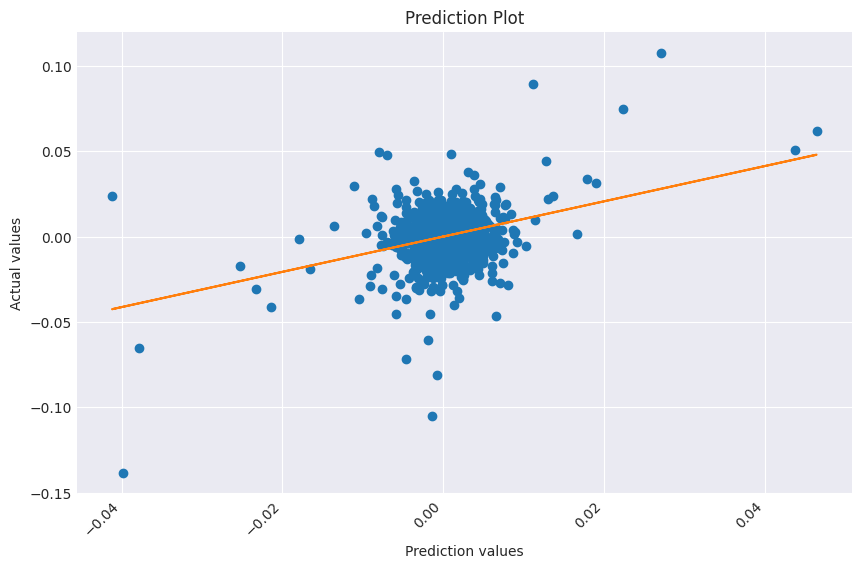

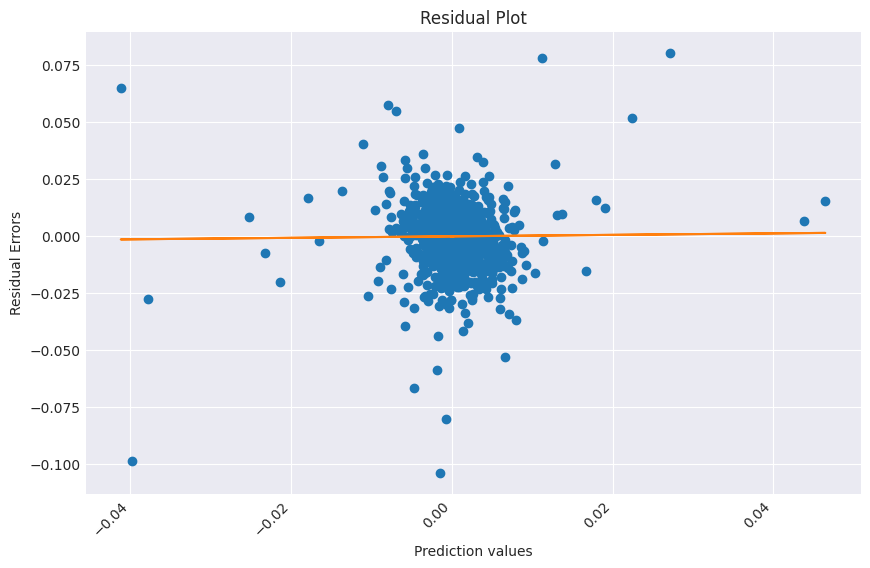


Prediction Metrics

Mean Forecast Error (MFE): -0.000028930514185691853
Mean Absolute Error (MAE): 0.0087277213604732
Max. Error: 0.10380622193407966
Residual Standard Error (RSE): 0.013164435261056068
Mean Absolute Percentage Error (MAPE): 5622787509.120616
Mean Absolute Standard Error (MASE): 0.6752796938191447

R-Squared: 0.1112983607713085
Mean Directional Accuracy (MDA): 0.7487091222030982%
Mean Sign Accuracy (MSA): 0.5279449699054171%

Directional Metrics

Won : 614.0
Lost : 549.0
Total : 1163.0
Diff : 65.0
Edge : 5.588993981083405%
IR : 1.9060026
Accuracy: 52.79%


Prediction Metrics

Mean Forecast Error (MFE): 0.000058020445387975934
Mean Absolute Error (MAE): 0.008717893589067221
Max. Error: 0.09845955503051462
Residual Standard Error (RSE): 0.013095212807126323
Mean Absolute Percentage Error (MAPE): 0.008738012000082123
Mean Absolute Standard Error (MASE): 0.6751149400913431

R-Squared: 0.11188301661204247
Mean Directional Accuracy (MDA): 0.7487091222030982%
Mean Sign Accura

In [15]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

y_trans = utils.getPeriodLogReturns(p.returns)["period"]
im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y_trans, "order":(3,0,2)})).generateInsights()
resid = result["ARIMAFit"].resid[1:]
yhat_trans = result["ARIMAFit"].predict()[1:]
yhat = np.exp(yhat_trans)
y = np.exp(y_trans)[1:]


im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"lags":30}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": y_trans[1:]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat_trans, "y_series": resid, "title": "Residual Plot", "y_label":"Residual Errors"}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y_trans[1:], "predictions": yhat_trans}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y, "predictions": yhat}))
#im.addInsightGenerator(im.createInsightGenerator("BasicPlot", opts={"log":False}))
#im.addInsightGenerator(im.createInsightGenerator("PerfSummary", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
#im.addInsightGenerator(im.createInsightGenerator("StatisticalTests", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
    
results = im.generateInsights()

ARIMA:4,1,3, AIC:-6703.613677079945, MFE:0.008945185576706639, MAE:0.017703619104337584


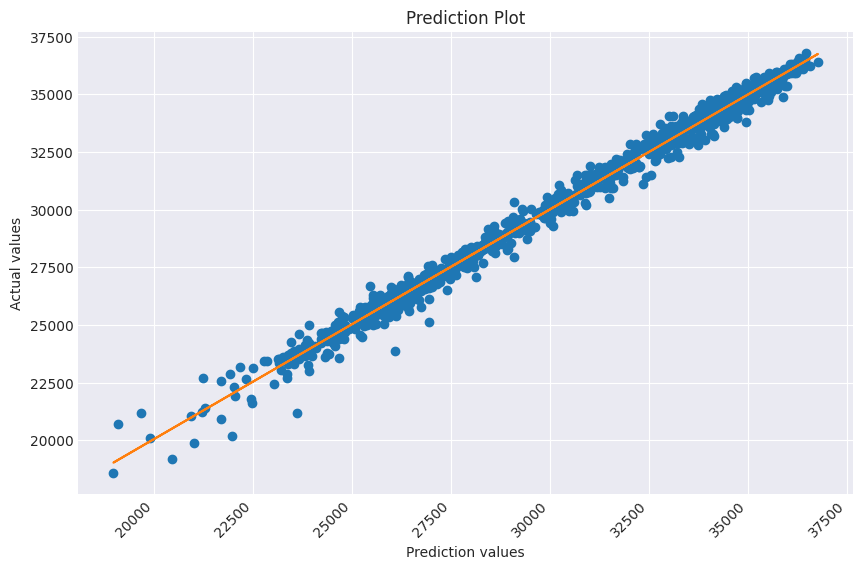

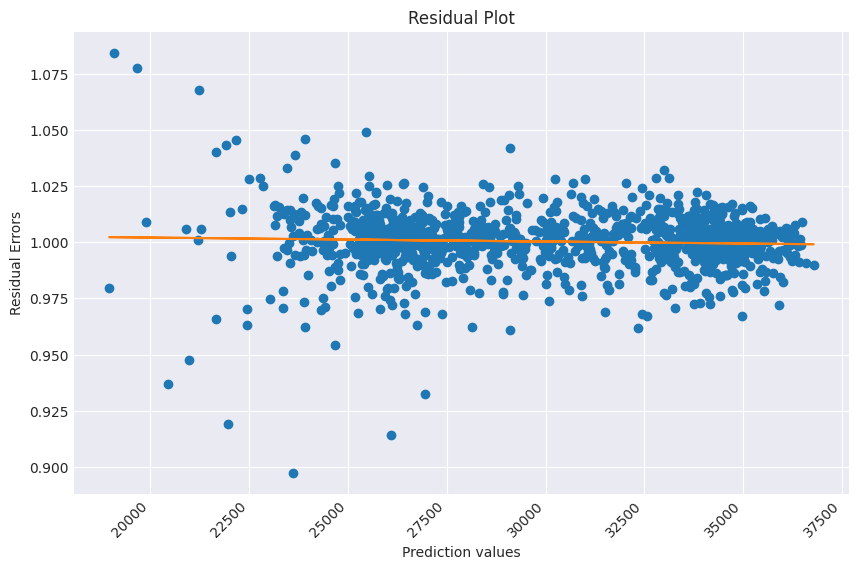


Prediction Metrics

R-Squared: 0.9913654905952412
Mean Forecast Error (MFE): 6.8795822090399295
Mean Absolute Error (MAE): 259.9217597659152
My Mean Absolute Error (MAE): 259.9217597659152
Max. Error: 2424.6050215201394
Mean Squared Error (MSE): 135167.353646035
My Mean Squared Error (MSE): 135167.353646035
Residual Standard Error (RSE): 367.6511303478271
Mean Absolute Percentage Error (MAPE): 0.00901153459130616
My Mean Absolute Percentage Error (MAPE): 0.00901153459130616
Mean Absolute Standard Error (MASE): 1.0403202188941643
Mean Directional Accuracy (MDA): 0.5025817555938038



In [6]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

y = np.log(p.findAsset("DOW").values["Close"])
im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y, "order": (4,1,3)})).generateInsights()
yhat = np.exp(result["ARIMAFit"].predict())[1:]
y = np.exp(y)[1:]
resid = np.exp(result["ARIMAFit"].resid[1:])

im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"lags":30}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat, "y_series": y}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat, "y_series": resid, "title": "Residual Plot", "y_label":"Residual Errors"}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y, "predictions": yhat}))
#im.addInsightGenerator(im.createInsightGenerator("BasicPlot", opts={"log":False}))
#im.addInsightGenerator(im.createInsightGenerator("PerfSummary", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
#im.addInsightGenerator(im.createInsightGenerator("StatisticalTests", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
    
results = im.generateInsights()

ARIMA:4,1,3, AIC:-6703.613677079945, MFE:0.008945185576706639, MAE:inf


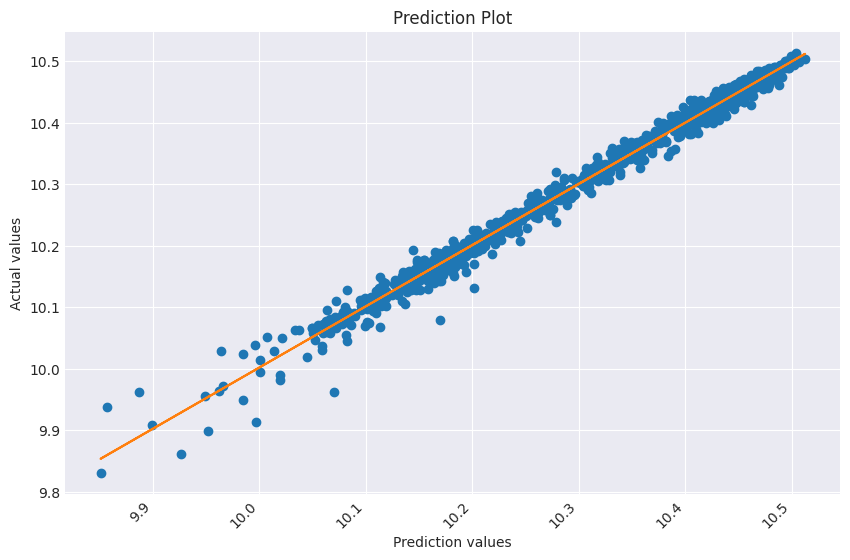

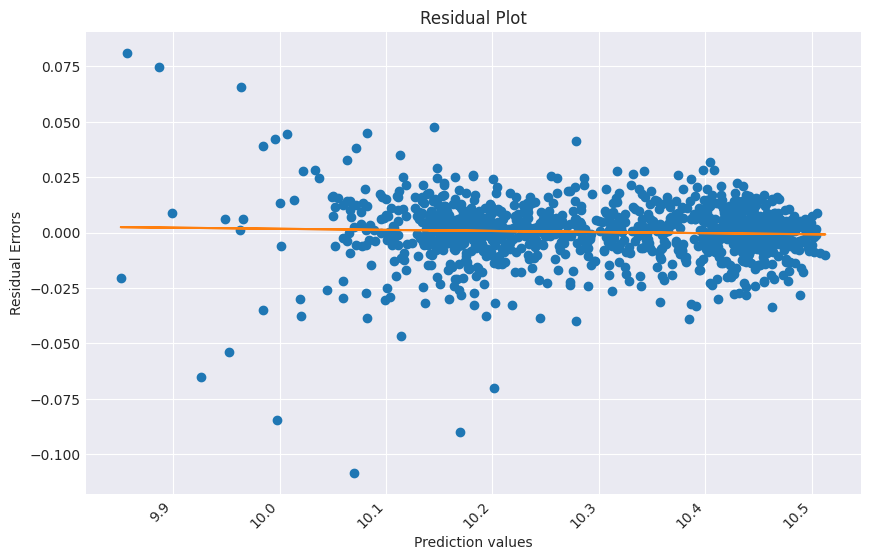


Prediction Metrics

Mean Absolute Error (MAE): 0.008999653463996553
Mean Absolute Percentage Error (MAPE): 0.0008775269546329428
Mean Squared Error (MSE): 0.0001811470654638928
Max. Error: 0.10828110640480126
R-Squared: 0.9900578903771249



In [6]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

y = np.log(p.findAsset("DOW").values["Close"])
im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y, "order": (4,1,3)})).generateInsights()
yhat = result["ARIMAFit"].predict()[1:]
y = y[1:]
resid = result["ARIMAFit"].resid[1:]

im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"lags":30}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat, "y_series": y}))
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"x_series": yhat, "y_series": resid, "title": "Residual Plot", "y_label":"Residual Errors"}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"actual": y, "predictions": yhat}))
#im.addInsightGenerator(im.createInsightGenerator("BasicPlot", opts={"log":False}))
#im.addInsightGenerator(im.createInsightGenerator("PerfSummary", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
#im.addInsightGenerator(im.createInsightGenerator("StatisticalTests", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
    
results = im.generateInsights()

In [17]:
env = SandboxEnvironment("TradeFair", "US/Eastern")
env.createAssets(marketData)

p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer"))
env.setPortfolio(p)

# Create baseline as an unweighted asset
baseline = env.createDerivative("Baseline Signal", weightGenerator=env.createModel("BuyAndHold", opts={"barOnly": True}))
baseline.addStoredAsset(["DOW"])
p.addAsset(baseline, weighted=False)

# Create baseline as an unweighted asset
baseline2 = env.createDerivative("MaxReturn", weightGenerator=env.createModel("MaxReturn", opts={"start":"19:00", "end":"20:00", "barOnly": True}))
baseline2.addStoredAsset(["DOW"])
#p.addAsset(baseline2, weighted=False)

# Create baseline as an unweighted asset
baseline3 = env.createDerivative("MinReturn", weightGenerator=env.createModel("MinReturn", opts={"start":"19:00", "end":"20:00", "barOnly": True}))
baseline3.addStoredAsset(["DOW"])
#p.addAsset(baseline3, weighted=False)

# BuyAndHold
""" p.addAsset(
    env.createDerivative(
        "BuyAndHold", 
        weightGenerator=env.createModel(
            "BuyAndHold", 
            #opts={"start":"19:00", "end":"20:00", "barOnly": True}
            opts={"barOnly": False}
        )).addStoredAsset(["DOW"])) """

# ARIMA
p.addAsset(
    env.createDerivative(
        "ARIMA", 
        weightGenerator=env.createModel(
            "ARIMA", 
            modelModule="tradeframework.models.remote",
            opts={"AR":3, "I":1, "MA":2, "window":5*4*3, "fit":"inSample", "barOnly": True}
        )).addStoredAsset(["DOW"]))

# ML Model
#p.addAsset(
#    env.createDerivative(
#        "mlmodel", 
#        weightGenerator=env.createModel(
#            "MIBasicModel", 
#            modelModule="tradeframework.models.remote",
#            opts={"window": 2, "modelSvr": modelsvr, "secret":"marketinsights-k8s-cred", "trainingRunId":"mlmodel", "threshold":0.8, "barOnly": True}
#        )).addStoredAsset(["DOW"]))

# Feed data into the portfolio
env.refresh()

im = InsightManager(p)
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"baseline":p.assets[0]}))
results = im.generateInsights()


Prediction Metrics

Mean Forecast Error (MFE): 0.00033273604025725964
Mean Absolute Error (MAE): 0.004307529999889254
Max. Error: 0.06718195590321195
Residual Standard Error (RSE): 0.009104730651874152
Mean Absolute Percentage Error (MAPE): 0.8895776507762356
Mean Absolute Standard Error (MASE): 0.6601930121507426

R-Squared: -0.8410746819405903

Directional Metrics

Won : 1371.0
Lost : 364.0
Total : 1735.0
Diff : 1007.0
Edge : 58.04034582132565%
IR : 24.175737
Mean Directional Accuracy (MDA): 79.02%



In [13]:
predictions = assembly.get_predictions_with_raw_data(marketData.xs("DOW"), training_id="mlmodel")
predictions

,0,1,2,3,4,5,6,7,8,9,y_pred0
Date_Time,,,,,,,,,,,
2018-08-02 15:00:00-04:00,0.111111,0.854167,0.000000,0.819444,0.805556,1.000000,0.319444,0.486111,0.284613,1.0,6.081961e-01
2018-08-03 15:00:00-04:00,0.367318,1.000000,0.132920,0.767032,0.767032,0.911863,0.000000,0.457361,0.082569,1.0,5.719656e-01
2018-08-06 15:00:00-04:00,0.806915,1.000000,0.026677,0.110852,0.112147,0.772727,0.000000,0.584823,0.302531,0.0,1.670068e-02
2018-08-07 15:00:00-04:00,0.739247,1.000000,0.000000,0.499866,0.496660,0.818595,0.189153,0.526583,0.145812,0.0,5.727510e-01
2018-08-08 15:00:00-04:00,0.258850,0.931969,0.000000,0.926438,0.926715,1.000000,0.621681,0.863938,0.141364,0.0,4.995912e-03
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13 15:00:00-04:00,0.291276,0.734563,0.000000,0.645286,0.644230,1.000000,0.583926,0.742167,0.889658,0.0,4.920740e-01
2023-03-14 15:00:00-04:00,0.930287,1.000000,0.156444,0.345516,0.345382,0.572711,0.000000,0.302435,0.929334,1.0,8.946470e-01
2023-03-15 15:00:00-04:00,0.036753,0.534095,0.000000,0.461735,0.474115,1.000000,0.309948,0.827428,1.471107,1.0,1.923854e-16


In [17]:
mlutils.evaluate(ppl.onehot(predictions[["y_pred0"]].values), ppl.onehot(predictions[[9]].values), threshold=0.5)

Won : 576.0
Lost : 579.0
Total : 1155.0
Diff : -3.0
Edge : -0.2597402597402597%
IR : -0.08827348


0.4987013

In [18]:
mlutils.evaluate(ppl.onehot(np.ones(predictions[[9]].values.shape)), ppl.onehot(predictions[[9]].values), threshold=0.5)

Won : 562.0
Lost : 593.0
Total : 1155.0
Diff : -31.0
Edge : -2.683982683982684%
IR : -0.91215926


0.48658007

In [138]:
import pandas as pd
import numpy as np
from tradeframework.api.core import Model
import statsmodels.api as sm
from typing import Literal
from tqdm import tqdm


class ARIMA(Model):
    """Creates a predictive model based on an ARIMA timeseries model"""

    def __init__(self, env, AR=0, I=0, MA=0, window=1000, fit: Literal["fitAll", "fitWindow", "fitOnce", "inSample"] = "inSample", params=None, barOnly=True):
        Model.__init__(self, env, window)
        self.AR = AR
        self.I = I
        self.MA = MA
        self.fit = fit
        self.params = params
        self.barOnly = barOnly

    def getSignals(self, window, idx=0):

        signals = pd.DataFrame(
            np.zeros((len(window), 2)),
            index=window.index,
            columns=["bar", "gap"],
        )

        if self.fit == "inSample" or self.params is not None:
            
            # For development and analysis purposes, get "predictions" of in-sample values
            model = sm.tsa.arima.ARIMA(window["Close"].values, order=(self.AR, self.I, self.MA))
            
            if self.params is not None:
                # Re-use provided model paramaters
                self.result = model.filter(params=self.params) 
            else:
                self.result = model.fit()

            predictions = self.result.predict(start=0, end=len(window)-1)
                
            predictionSignals = np.sign(
                predictions - window["Close"].shift().values
            )

            predictionSignals = pd.DataFrame(
                np.array([predictionSignals, predictionSignals]).T,
                index=window.index,
                columns=["bar", "gap"],
            )
            
        elif len(window) > self.window:

            dataLen = len(window) - self.window
            self.result = sm.tsa.arima.ARIMA(
                window[: self.window]["Close"].values, order=(self.AR, self.I, self.MA)
            ).fit()
            
            if self.fit == "fitOnce":            

                # Fit to an initial window, then predict all based on fitted model.
                self.result = self.result.append(window[self.window:]["Close"].values)    
                predictions = self.result.predict(start=self.window, end=len(window)-1)
                    
            else:
                predictions = np.array([self.result.forecast()[0]])

                for i in tqdm(range(1, dataLen)):
                    if self.fit == "fitAll":
                        # Fit to an ever increasing window and predict next step

                        predictions = np.array([self.result.forecast()[0]])
                        self.result = self.result.append(
                            window[self.window + i - 1 : self.window + i]["Close"].values,
                            refit=True
                        )
                    elif self.fit == "fitWindow":
                        # Fit to an rolling window and predict next step
                        self.result = sm.tsa.arima.ARIMA(
                            window[i:i+self.window]["Close"].values, order=(self.AR, self.I, self.MA)
                        ).fit()
                        
                    predictions = np.append(predictions, self.result.forecast()[0])

            predictionSignals = np.sign(
                predictions - window[self.window - 1 : -1]["Close"].values
            )

            predictionSignals = pd.DataFrame(
                np.array([predictionSignals, predictionSignals]).T,
                index=window[self.window :].index,
                columns=["bar", "gap"],
            )

        if self.barOnly:
            predictionSignals["gap"] = 0

        signals.update(predictionSignals)

        return signals[idx:]


In [33]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 9498#24*5*4*3
x = x.iloc[-window-100:]
r = len(x) - window
predictions = np.array([sm.tsa.arima.ARIMA(x[i:i+window]["Close"].values, order=(3, 1, 5)).fit().forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

array([ 1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.])

In [238]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-1000:]
r = len(x) - window
params = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit().params
predictions = np.array([sm.tsa.arima.ARIMA(x[i:i+window]["Close"].values, order=(3, 1, 5)).filter(params).forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([-1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
       -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1

In [280]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
predictions = np.array([res.apply(x[i:i+window]["Close"].values, refit=True).forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

array([ 1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.])

In [290]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-100:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = np.array([res.forecast()[0]])
for i in range(1, r):
    res = res.append(x[window+i-1:window+i]["Close"].values, refit=True)
    #print(x[window+i-1:window+i]["Close"].values)
    predictions = np.append(predictions, res.forecast()[0])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([-1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
       -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.])

In [62]:
import statsmodels.api as sm
x = marketData.xs("DOW")
#window = 24*5*4*3
#x = x.iloc[-10:]
#r = len(x) - window
res = sm.tsa.arima.ARIMA(x["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = res.predict(start=len(x)-10, end=len(x)-1)
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

ValueError: operands could not be broadcast together with shapes (10,) (8068,) 

In [190]:
import statsmodels.api as sm
y = marketData.xs("DOW")
window = 24*5*4*3
x = y.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = np.array([res.forecast()[0]])
for i in range(1, r):
    res = res.extend(x[window+i-1:window+i]["Close"].values)
    #print(x[window+i-1:window+i]["Close"].values)
    predictions = np.append(predictions, res.forecast()[0])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.])

In [112]:
import statsmodels.api as sm
y = marketData.xs("DOW")
window = 24*5*4*3
x = y.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(4,1,3)).fit()
#print(x[:window]["Close"].values)
#predictions2 = np.array([res.forecast()[0]])

result = res.append(x[window:]["Close"].values)
    #print(x[window+i-1:window+i]["Close"].values)
predictions2 = result.predict(start=len(x)-10, end=len(x)-1)
signals2 = np.sign(predictions2 - x[window-1:-1]["Close"].values)
signals2

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.])

In [106]:
predictions2

array([32245.82203025, 32247.70379636, 32247.58775146, 32007.59730162,
       31851.92708551, 31808.49112529, 31901.06410835, 31912.91038558,
       31809.23428615, 31860.44674748])

In [73]:
mod = sm.tsa.arima.ARIMA(x[1:]["Close"].values, order=(1, 1, 0)).filter(res.params)
result.initialize(mod, res.params)

In [107]:
mod = sm.tsa.arima.ARIMA(x[window:]["Close"].values, order=(1, 1, 0))
res2 = mod.filter(res.params)
#res2.initialize(mod, params=res.params)

In [108]:
res2.predict()

array([    0.        , 32257.63030248, 32247.58775146, 32007.59730162,
       31851.92708551, 31808.49112529, 31901.06410835, 31912.91038558,
       31809.23428615, 31860.44674748])

In [109]:
res2.predict()

array([    0.        , 32257.63030248, 32247.58775146, 32007.59730162,
       31851.92708551, 31808.49112529, 31901.06410835, 31912.91038558,
       31809.23428615, 31860.44674748])

In [114]:
res2.params

array([2.10321582e-02, 1.49452129e+04])

In [113]:
res.params

array([-9.93115257e-01, -1.23047954e-01,  4.73227172e-01, -4.17102544e-02,
        1.01873311e+00,  1.22286132e-01, -5.32034052e-01,  1.48711161e+04])

In [18]:
y = marketData.xs("DOW")
len(y)

9508

In [113]:
x = marketData.xs("DOW")["Close"]
np.log(x).diff()[1:]

Date_Time
2018-08-03 00:00:00+00:00    0.000611
2018-08-06 00:00:00+00:00    0.005526
2018-08-07 00:00:00+00:00    0.004957
2018-08-08 00:00:00+00:00   -0.001764
2018-08-09 00:00:00+00:00   -0.002917
                               ...   
2023-03-13 00:00:00+00:00   -0.002840
2023-03-14 00:00:00+00:00    0.010514
2023-03-15 00:00:00+00:00   -0.008771
2023-03-16 00:00:00+00:00    0.011600
2023-03-17 00:00:00+00:00   -0.011996
Name: Close, Length: 1163, dtype: float64

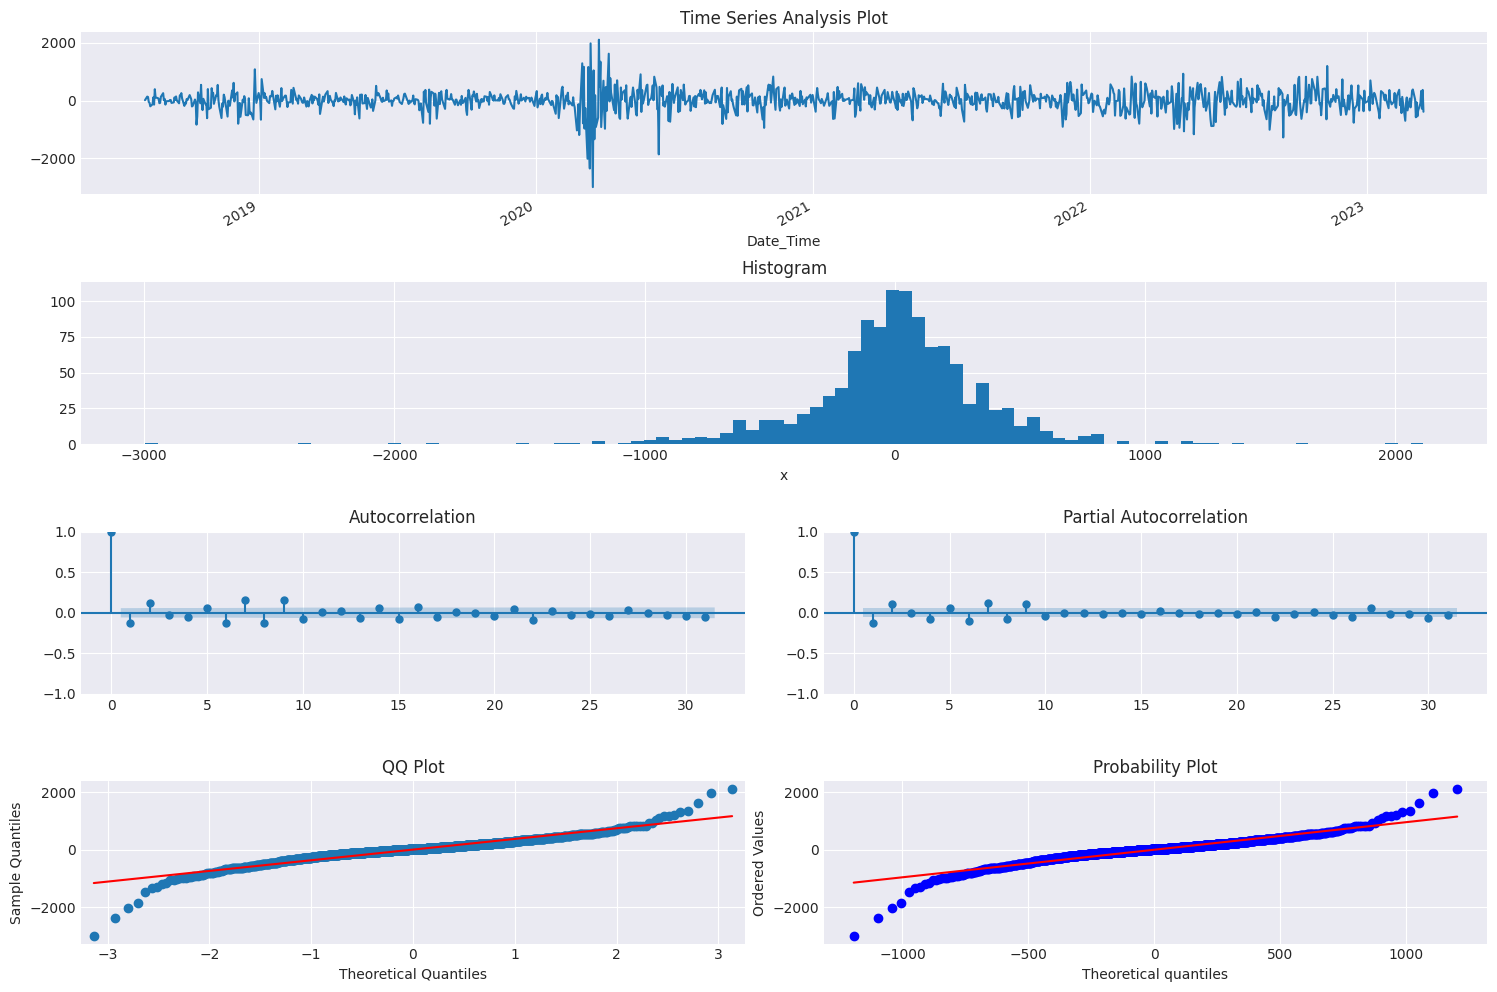

In [119]:
a = tsplot(x.diff()[1:])
a


In [115]:
import matplotlib.pyplot as plt
def histogram(
    x,
    figsize=(10, 6),
    style="seaborn-darkgrid",
    title="Histogram",
    x_axis="x",
    ax = None,
    show=False
):
    if not isinstance(x, pd.Series):
        x = pd.Series(x)

    with plt.style.context(style):
        if ax is None:
            _,ax = plt.subplots(figsize=figsize)
        counts, bins = np.histogram(x, bins=100)
        # plt.stairs(counts, bins)
        ax.hist(bins[:-1], bins, weights=counts)

        ax.autoscale_view()
        #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment="right")
        ax.set_xlabel(x_axis)
        ax.set_title(title)
        # ax.legend(loc="best")
        if not show:
            plt.close()
        return ax.get_figure()

In [116]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy import stats as scipy_stats
def tsplot(y, lags=None, figsize=(15, 10), style="seaborn-darkgrid", title=None, show=False):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        # mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (4, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        hs_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (2, 1))
        qq_ax = plt.subplot2grid(layout, (3, 0))
        pp_ax = plt.subplot2grid(layout, (3, 1))
        
        y.plot(ax=ts_ax)
        description = "Time Series Analysis Plot"
        if title:
            description = f"{description}: {title}"
        ts_ax.set_title(description)
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line="s", ax=qq_ax)
        qq_ax.set_title("QQ Plot")
        scipy_stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        #scatterPlot(range(len(y)), y, ax=r_ax)
        histogram(y, ax=hs_ax)

        plt.tight_layout()
        if not show:    
            plt.close()
    return fig

In [117]:
def scatterPlot(
    x,
    y,
    bestFit=True,
    figsize=(10, 6),
    style="seaborn-darkgrid",
    title="Scatter Plot",
    x_axis="x",
    y_axis="y",
    ax=None,
    show=False
):
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        if ax is None:
            ax = plt.subplots(figsize=figsize)
        ax.plot(x, y, "o", label="data")

        if bestFit:
            a, b = np.polyfit(x, y, 1)
            ax.plot(x, a * x + b)
        ax.autoscale_view()
        #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment="right")
        ax.set_xlabel(x_axis)
        ax.set_ylabel(y_axis)
        ax.set_title(title)
        # ax.legend(loc="best")
        if not show:
            plt.close()
        return ax.get_figure()